Wczytanie bibliotek

In [102]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


Wczytanie danych i wstępny preprocessing

In [103]:
# wczytanie pliku CSV
df = pd.read_csv("syntetyczne_dane_trywialne.csv", sep=';')
df = df.replace(',', '.', regex=True)

# pobranie wartości
X = df.drop('Class', axis=1)
# preprocessing
X = X.astype(float)
# pobranie predykcji
y = df['Class'].values



Definiowanie XGBoost przy użyciu wbudowanych funkcji kroswalidacji i trenowanie

In [104]:
# definicja paremetrow dla xgboost
# korzystałem z strony https://xgboost.readthedocs.io/en/stable/python/python_intro.html
param = {'max_depth': 5, 'eta': 1, 'objective': 'binary:logistic', 'eval_metric': 'auc'}

# max_depth -> maksymalna głebokosc drzewa, wyzsze wartosci prowadza do overfittingu
# eta -> predkosc uczenia
# konwersja danych DMatrix do formatu XGboost
dtrain = xgb.DMatrix(X, label=y)

# wykonanie kroswalidacji
skf_results = xgb.cv(param, dtrain, num_boost_round=10, nfold=5, stratified=True, seed=42, metrics='auc')
# AUC czyli zdolność do rozrózniania między klasami
print(skf_results)
print(f"Średnia wartość AUC: {skf_results['test-auc-mean'].iloc[-1]}")


   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.994854       0.001773        0.98500      0.007499
1        0.999302       0.000527        0.99245      0.005920
2        0.999837       0.000046        0.99414      0.004775
3        0.999946       0.000021        0.99478      0.004558
4        0.999982       0.000012        0.99532      0.004574
5        0.999995       0.000005        0.99534      0.005192
6        0.999999       0.000003        0.99548      0.005005
7        0.999999       0.000003        0.99543      0.005125
8        1.000000       0.000000        0.99571      0.004420
9        1.000000       0.000000        0.99604      0.004601
Średnia wartość AUC: 0.9960399979998


Podział na zbiory testowy treningowy i walidacyjny oraz trenowanie modelu na zbiorze walidacyjnym

In [105]:

# podział na dane treningowe i testowe (70% treningowe, 30% testowe)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# podział zbioru treningowego na zbiór treningowy i walidacyjny (70% treningowe, 30% walidacyjne)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

accuracies = [] #  procent do poprawnych przewidywań w stosunku do wszystkich przewidywań
precisions = [] #  pokazuje jak wiele przypadkow pozytywnych jest prawdziwie pozytywnych
recalls = [] # pokazuje jak wiele rzeczywiscie pozytywnych przypadkow model poprawnie wykryl
f1_scores = []  # harmoniczna srednia precyzji i czulosci
log_losses = [] # roznica pomiedzy przewidywaniami a rzeczywywistymi klasami im mniej tym lepiej
aucs = [] # zdolnosc do rozrozniania miedzy klasami, lecz za pomoca innej biblioteki

# konwersja danych do formatu DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# trenowanie modelu
num_round = 10
bst = xgb.train(param, dtrain, num_round)

# predykcja na zbiorze walidacyjnym
y_pred_proba = bst.predict(dval)
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_proba]

# obliczanie różnych miar na zbiorze walidacyjnym
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
logloss = log_loss(y_val, y_pred_proba)
auc = roc_auc_score(y_val, y_pred_proba)



In [106]:

print("\nWyniki na zbiorze walidacyjnym:")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Log Loss: ", logloss)
print("AUC: ", auc)


Wyniki na zbiorze walidacyjnym:
Accuracy:  0.9857142857142858
Precision:  0.9903846153846154
Recall:  0.9809523809523809
F1 Score:  0.9856459330143541
Log Loss:  0.0787958085252714
AUC:  0.9900226757369615


Predykcja na zbiorze testowym i ocena finalna modeu

In [107]:
# predykcje na zbiorze testowym
y_pred_proba_test = bst.predict(dtest)
y_pred_test = [1 if prob >= 0.5 else 0 for prob in y_pred_proba_test]

# policzenie odpowiednich miar 
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
logloss_test = log_loss(y_test, y_pred_proba_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)


print("\nWyniki na zbiorze testowym:")
print("Accuracy: ", accuracy_test)
print("Precision: ", precision_test)
print("Recall: ", recall_test)
print("F1 Score: ", f1_test)
print("Log Loss: ", logloss_test)
print("AUC: ", auc_test)


Wyniki na zbiorze testowym:
Accuracy:  0.9866666666666667
Precision:  0.9929078014184397
Recall:  0.9790209790209791
F1 Score:  0.9859154929577465
Log Loss:  0.0484691928992278
AUC:  0.9973275132510802


Wyświetlenie ważnosci cech wytrenowanego modelu z róznymi hyperparametrami
### Parametry `importance_type` w XGBoost

XGBoost posiada różne hyperparametry które pozwalają obliczać ważnosć cech

1. **`gain`**:
   - Określa jak bardzo dana cecha poprawia tak zwany "zysk" w modelu
   - Jest to średni przyrost "zysku" w obrębie drzewa, które zostało stworzone przez daną cechę, im wyższa wartość tym bardziej istotna jest dana cecha
   
   Przykład: 
   Drzewo decyzyjne dokonało podziału który zmniejszył błąd z **0.7 do 0.3** co oznacza ze nasze **`Gain wzrośnie o 0.4`**

2. **`weight`**:
   - Określa ile razy dana cecha pojawiła się w modelu
   - Wysoka liczba oznacza że cecha była używana w wielu drzewach

3. **`cover`**:
   - Określa, jak dużą część danych jest w stanie podzielić dana cecha
   - **Cover** mierzy średnią liczbę próbek, które są dzielone przez daną cechę w obrębie drzewa. Im większa wartość, tym większa liczba próbek jest rozdzielana przez tę cechę, co może wskazywać na jej znaczenie

4. **`total_gain`**:
   - **Total_gain** jest sumą "gain" dla danej cechy w całym procesie budowania modelu, co daje pełny obraz, jak mocno cecha wpływa na jakość modelu.

5. **`total_cover`**:
   - Jest łączną miarą tego, jak często dana cecha była wykorzystywana do podziału próbek w modelu. Wysoka wartość oznacza, że cecha miała duży wpływ na rozdzielanie próbek w wielu drzewach


### Podsumowanie
- **`Gain`** i **`Total_gain`** są miarami jakościową (jak bardzo cecha przyczynia się do poprawy modelu)
- **`Weight`** i **`Cover`** są miarami ilościową (jak często cecha była używana w modelu i jak wielu próbek dotyczyła)


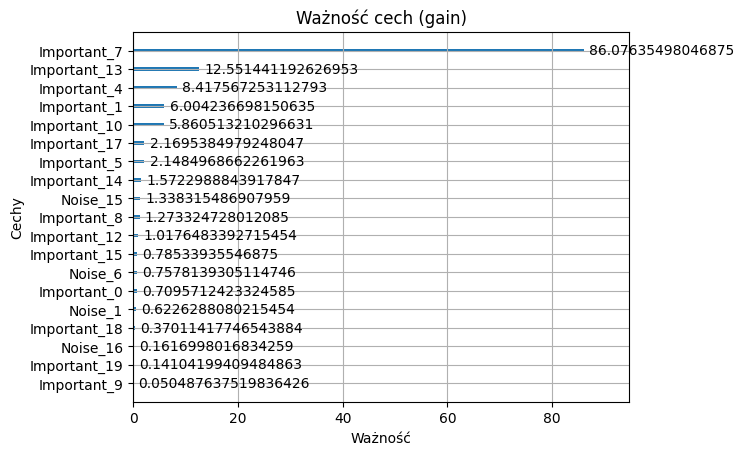

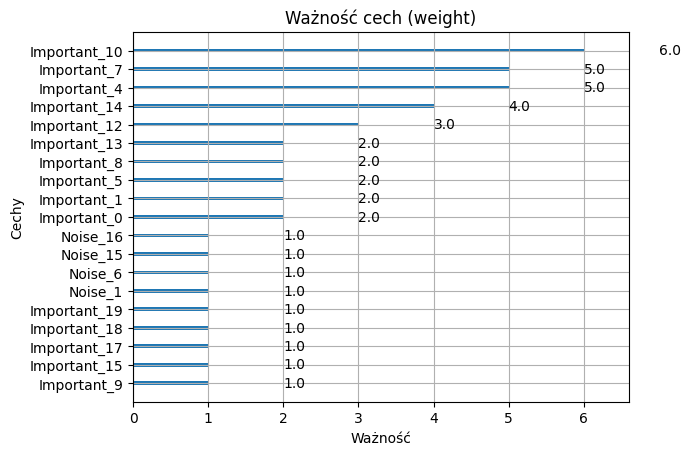

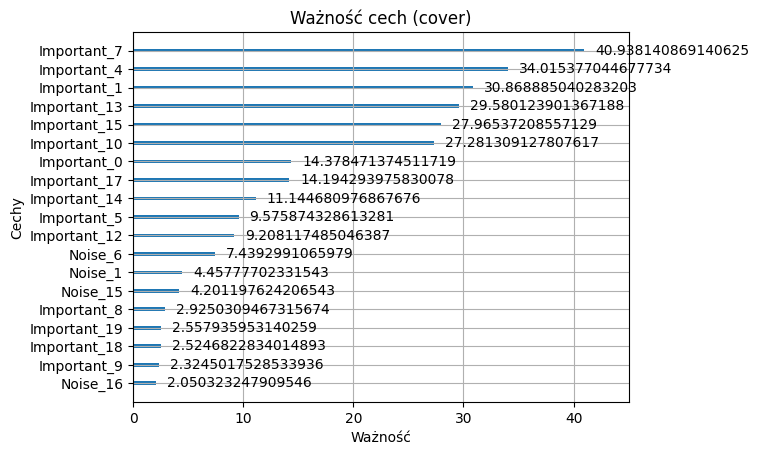

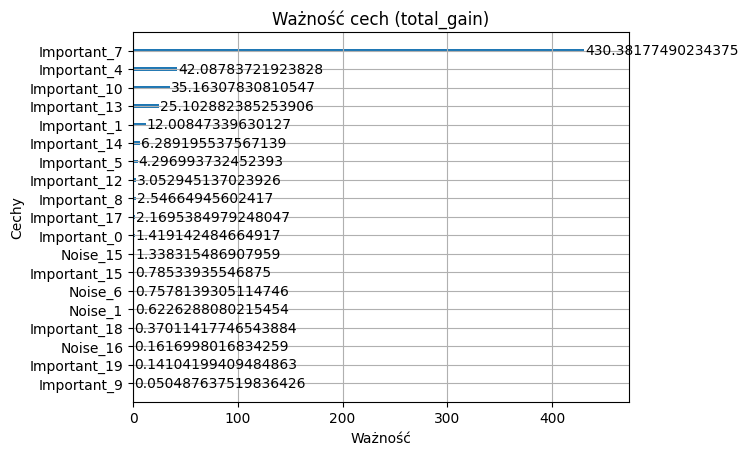

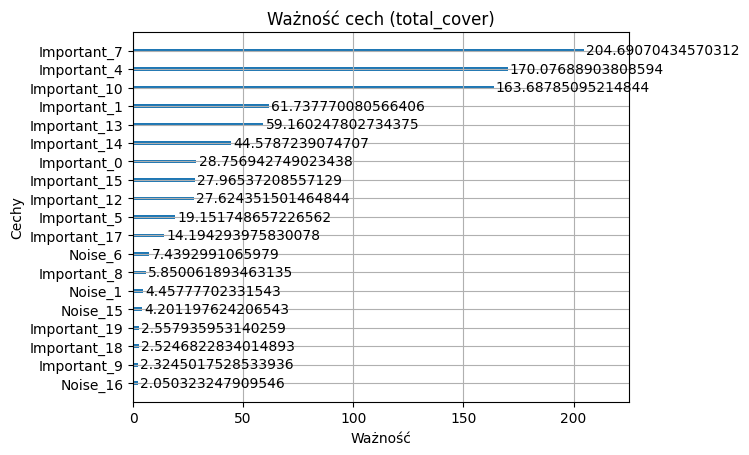

In [108]:

hyper_parameters = ['gain' , 'weight', 'cover', 'total_gain', 'total_cover'] 
for parameter in hyper_parameters:
    xgb.plot_importance(bst, importance_type=parameter)
    plt.title(f'Ważność cech ({parameter})')
    plt.xlabel('Ważność')
    plt.ylabel('Cechy')
    plt.show()


Selekcjonowanie cech na podstawie róznych wartości

In [109]:
# wyświetlenie wartości hyperparametru dla róznych cech

for parameter in hyper_parameters: 
    print(f"Selekcja cech zależności od hyperametru: {parameter}")
    importance = bst.get_score(importance_type=parameter) # pobranie istotności dla każdej cechy
    importance_df = pd.DataFrame({'Cecha': list(importance.keys()), 'Istotność': list(importance.values())}) # zapisanie istotności w tablicy wraz z dana cechą

    # obliczenie średniej istotności dla hyperparametru
    mean_importance = importance_df['Istotność'].mean()
    # wybór cech które maja więcej niż średnia
    selected_features_mean = importance_df[importance_df['Istotność'] > mean_importance]['Cecha']
    # wybór cech dla tresholdu
    threshold = importance_df['Istotność'].quantile(0.75)
    selected_features_treshold = importance_df[importance_df['Istotność'] > threshold]['Cecha']

    print(f"- Średnia ważność cechy {parameter}: {mean_importance}")
    # wykonanie kroswalidacji i obliczenie AUC dla średniej
    X_filtered_mean = X[selected_features_mean]
    dtrain_mean = xgb.DMatrix(X_filtered_mean, label=y)
    
    skf_results_mean = xgb.cv(param, # parametry podane wyżej
                            dtrain_mean, 
                            num_boost_round=10, # liczba iteracji - liczba drzew w modelu 
                            nfold=5, # krotna kroswalidacja - dzielienie na 5 części
                            stratified=True, # każda ma taki sam rozkład
                            seed=42, # losowość
                            metrics='auc' # miara jakości Area under Curve 
                            )

    # wykonanie kroswalidacji i obliczenie AUC dla trehsoldu 75%
    X_filtered_treshold = X[selected_features_treshold]
    dtrain_treshold = xgb.DMatrix(X_filtered_treshold, label=y)
    skf_results_treshold = xgb.cv(param, dtrain_treshold, num_boost_round=10, nfold=5, stratified=True, seed=42, metrics='auc')

    # wykonanie kroswalidacji i obliczenie AUC dla mediany
    median_importance = importance_df['Istotność'].median()
    selected_features_median = importance_df[importance_df['Istotność'] > median_importance]['Cecha']
    X_filtered_median = X[selected_features_median]
    dtrain_median = xgb.DMatrix(X_filtered_median, label=y)
    skf_results_median = xgb.cv(param, dtrain_median, num_boost_round=10, nfold=5, stratified=True, seed=42, metrics='auc')

    # print(skf_results)
    print(f"- Średnia wartość AUC dla wszystkich cech: {skf_results['test-auc-mean'].iloc[-1]}")
    # print(skf_results_mean)
    print(f"- Średnia wartość AUC dla cech, które są powyżej średniej: {skf_results_mean['test-auc-mean'].iloc[-1]}")
    # print(skf_results_treshold)
    print(f"- Średnia wartość AUC dla cech, które są powyżej tresholdu: {skf_results_treshold['test-auc-mean'].iloc[-1]}")
    # print(skf_results_median)
    print(f"- Średnia wartość AUC dla cech, które są powyżej mediany: {skf_results_median['test-auc-mean'].iloc[-1]}")
    


Selekcja cech zależności od hyperametru: gain
- Średnia ważność cechy gain: 6.948864899183574
- Średnia wartość AUC dla wszystkich cech: 0.9960399979998
- Średnia wartość AUC dla cech, które są powyżej średniej: 0.9954799879987999
- Średnia wartość AUC dla cech, które są powyżej tresholdu: 0.9959
- Średnia wartość AUC dla cech, które są powyżej mediany: 0.9949199999999999
Selekcja cech zależności od hyperametru: weight
- Średnia ważność cechy weight: 2.210526315789474
- Średnia wartość AUC dla wszystkich cech: 0.9960399979998
- Średnia wartość AUC dla cech, które są powyżej średniej: 0.9946299919991999
- Średnia wartość AUC dla cech, które są powyżej tresholdu: 0.9946299919991999
- Średnia wartość AUC dla cech, które są powyżej mediany: 0.9946299919991999
Selekcja cech zależności od hyperametru: cover
- Średnia ważność cechy cover: 14.612178639361733
- Średnia wartość AUC dla wszystkich cech: 0.9960399979998
- Średnia wartość AUC dla cech, które są powyżej średniej: 0.9953899959996001


Tworzenie własnej miary i pokazanie wykresów istotności danych cechy
- Będzie to maira `Special_score`, która będzie liczona poprzez nastepujący wzór:
- `Special_score` = **(gain+cover) * weight**


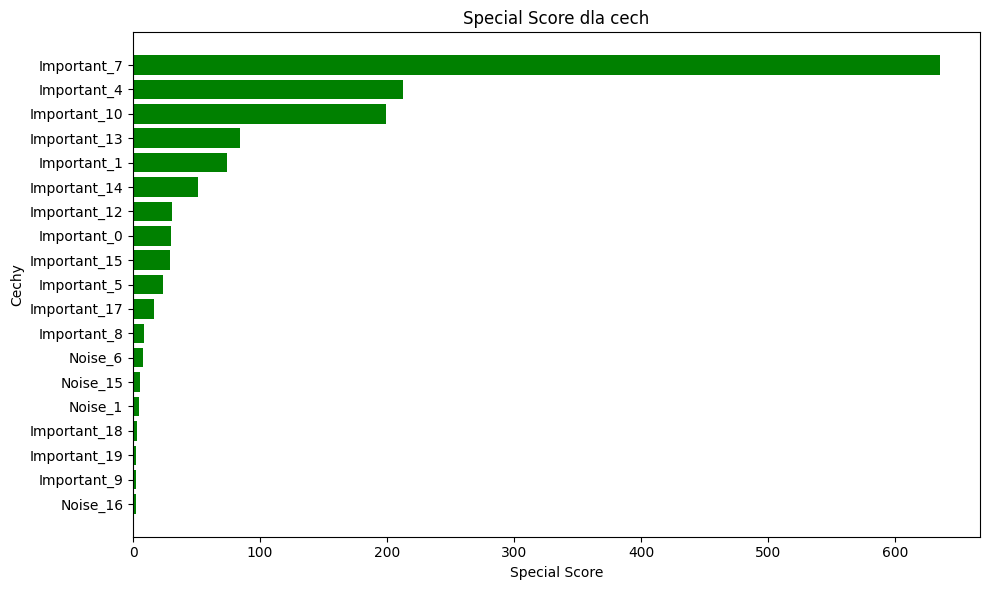

In [110]:

importance_gain = bst.get_score(importance_type='gain')
importance_cover = bst.get_score(importance_type = 'cover')
importance_weight = bst.get_score(importance_type = 'weight')

# konwersja do DataFrame aby łatwiej operować na danych
importance_df_score = pd.DataFrame({
    'Cecha': list(importance_gain.keys()),  
    'Gain': list(importance_gain.values()),  
    'Cover': [importance_cover.get(feat, 0) for feat in importance_gain.keys()], # dodanie 0, jezeli brak cechy 
    'Weight': [importance_weight.get(feat, 0) for feat in importance_gain.keys()]  # dodanie 0, jezeli brak cechy
})

# obliczenie special_score
importance_df_score['Special_Score'] = (importance_df_score['Gain'] + importance_df_score['Cover']) * importance_df_score['Weight']

# posortowanie 
importance_df_sorted = importance_df_score.sort_values(by='Special_Score')

plt.figure(figsize=(10, 6))
plt.barh(importance_df_sorted['Cecha'], importance_df_sorted['Special_Score'], color='green')
plt.xlabel('Special Score')
plt.ylabel('Cechy')
plt.title('Special Score dla cech')
plt.tight_layout()
plt.show()

# Generowanie danych syntetycznych

In [111]:
# import numpy as np
# import pandas as pd
# from sklearn.datasets import make_classification

# # ziarno losowe
# np.random.seed(42)

# # generowanie 20 istotnych cech
# X_important, y = make_classification(n_samples=1000, # liczba próbek
#                                     n_features=20, # całkowita liczba cech 
#                                     n_informative=10, # liczba cech istotnych
#                                     n_redundant=10, # liczba cech kombinacji liniowej 
#                                     n_classes=2, # liczba klas
#                                     class_sep= 3.0, # trudność sklasifykowania
#                                     random_state=42)

# # generowanie 20 cech nieistotnych (losowe wartości)
# X_noise = np.random.randn(1000, 20)

# # połączenie wszystkich cech
# X_final = np.hstack((X_important, X_noise))

# # nazwy cech
# important_features = [f'Important_{i}' for i in range(20)]
# noise_features = [f'Noise_{i}' for i in range(20)]

# # tworzenie DataFrame
# column_names = important_features + noise_features
# df = pd.DataFrame(X_final, columns=column_names)
# df['Class'] = y 

# # Zapis do CSV
# df.to_csv("syntetyczne_dane_trywialne.csv", index=False, sep = ";")
